#***Setup***

In [1]:
import os
import torch
import pandas as pd
import numpy as np

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


#***Reading trainning and validation data (train/val_data/labels)***

In [48]:
# from google.colab import drive
# drive.mount('/content/drive')
# path='drive/MyDrive/CS505/CS505-Final/'
path='../'

In [49]:
eng_path=path+'data/2017_English_final/GOLD/Subtask_A/'
train_file=[]
val_file=[]

for root, dirs, files in os.walk(eng_path):
    for file_name in files:
        if 'train' in file_name and '.txt' in file_name:
            train_file.append(os.path.join(eng_path, file_name))
        if 'dev' in file_name and '.txt' in file_name:
            val_file.append(os.path.join(eng_path, file_name))
print(train_file)
print(val_file)


[]
[]


In [5]:
train_data = []
train_labels = []
val_data = []
val_labels = []


sentiment_to_label = {'positive': 2, 'neutral': 1, 'negative': 0}

for file_path in train_file:
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for l in lines:
            entries = l.split('\t')
            train_data.append(entries[2])
            train_labels.append(sentiment_to_label[entries[1]])
            
    
for file_path in val_file:
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for l in lines:
            entries = l.split('\t')
            val_data.append(entries[2])
            val_labels.append(sentiment_to_label[entries[1]])
            

train_data = np.array(train_data)
train_labels = np.array(train_labels)
val_data = np.array(val_data)
val_labels = np.array(val_labels)

#***Tokenize***

###Get tokenizer

In [6]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.8.6/install/bin/python3.8 -m pip install --upgrade pip' command.


In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

###Find max length of train and validation

In [8]:
max_len = 0

# For every sentence...
for sent in train_data:

    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  118


In [9]:
max_len_val = 0

# For every sentence...
for sent in val_data:

    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_val = max(max_len_val, len(input_ids))

print('Max sentence length: ', max_len_val)

Max sentence length:  114


###Tokenizing

In [10]:
def tokenize(d,l):
  input_ids=[]
  attention_masks = []
  # For every sentence...
  for sent in d:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True, 
                        max_length = max_len+100,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  label = torch.tensor(l)
  return input_ids,attention_masks,label

In [11]:
train_input_ids, train_attention_masks,train_label=tokenize(train_data,train_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr4/cs523/tengzi/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
val_input_ids, val_attention_masks, val_label=tokenize(val_data,val_labels)

In [13]:
print('Original: ', train_data[0])
print('Token IDs:', train_input_ids[0])
print(tokenizer.decode(train_input_ids[0]))

Original:  I forgot how sad the first episode of the 5th season of Dexter is. #depressing #dexter #darkpassenger

Token IDs: tensor([    0,    87,   100,  9904,  3642, 17110,    70,  5117, 50094,   111,
           70,   190,   927, 34003,   111,   262,   425,   720,    83,     5,
          468,   112, 11856,   214,   468, 39659,   720,   468,  1506,    92,
        70154,  1505,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,   

###Load data

In [14]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_label)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_label)

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#***Model***

In [16]:
from transformers import AutoModelForMaskedLM,XLMRobertaForSequenceClassification
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",
                                             num_labels = 3,
                                             output_attentions = False,
                                             output_hidden_states = False, 
)

model.cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [17]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr4/cs523/tengzi/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [19]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [20]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,011.    Elapsed: 0:00:09.
  Batch    80  of  1,011.    Elapsed: 0:00:18.
  Batch   120  of  1,011.    Elapsed: 0:00:27.
  Batch   160  of  1,011.    Elapsed: 0:00:37.
  Batch   200  of  1,011.    Elapsed: 0:00:46.
  Batch   240  of  1,011.    Elapsed: 0:00:55.
  Batch   280  of  1,011.    Elapsed: 0:01:04.
  Batch   320  of  1,011.    Elapsed: 0:01:14.
  Batch   360  of  1,011.    Elapsed: 0:01:23.
  Batch   400  of  1,011.    Elapsed: 0:01:32.
  Batch   440  of  1,011.    Elapsed: 0:01:41.
  Batch   480  of  1,011.    Elapsed: 0:01:51.
  Batch   520  of  1,011.    Elapsed: 0:02:00.
  Batch   560  of  1,011.    Elapsed: 0:02:09.
  Batch   600  of  1,011.    Elapsed: 0:02:18.
  Batch   640  of  1,011.    Elapsed: 0:02:28.
  Batch   680  of  1,011.    Elapsed: 0:02:37.
  Batch   720  of  1,011.    Elapsed: 0:02:46.
  Batch   760  of  1,011.    Elapsed: 0:02:55.
  Batch   800  of  1,011.    Elapsed: 0:03:04.
  Batch   840  of

In [37]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.78,0.82,0.63,0:03:53,0:00:23
2,0.57,0.79,0.63,0:03:53,0:00:23
3,0.44,0.96,0.64,0:03:53,0:00:23
4,0.34,1.03,0.64,0:03:53,0:00:23


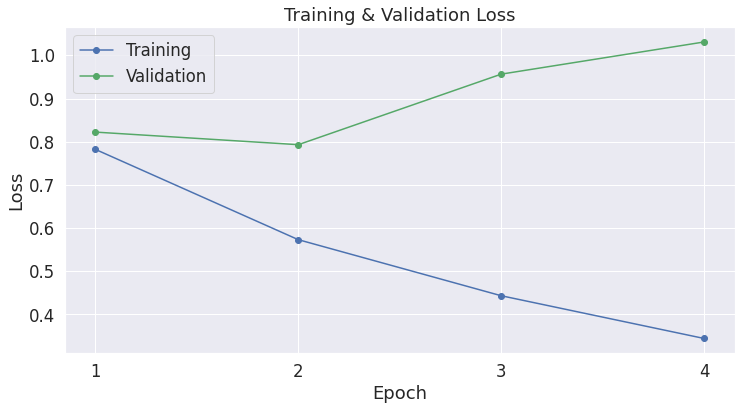

In [39]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#***Reading test data***

In [21]:
arabic_path=path+'data/2017_Arabic_train_final/GOLD/SemEval2017-task4-train.subtask-A.arabic.txt'

test_data = []
test_labels = []

sentiment_to_label = {'positive': 2, 'neutral': 1, 'negative': 0}

with open(arabic_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for l in lines:
        entries = l.split('\t')
        test_data.append(entries[2])
        test_labels.append(sentiment_to_label[entries[1]])

In [32]:
len(test_input_ids)

3355

In [31]:
test_input_ids, test_attention_masks, test_label=tokenize(test_data,test_labels)

In [33]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_label)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [34]:
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,355 test sentences...
    DONE.


In [35]:
total_val_accuracy=0
for i in range(len(predictions)):
  total_val_accuracy += flat_accuracy(predictions[i], true_labels[i])

avg_accuracy = total_val_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.3f}".format(avg_accuracy))

  Accuracy: 0.544


***test on translated***

In [43]:
trans_path=path+'data/2017_Arabic_train_final/GOLD/SemEval2017-task4-train.subtask-A.english.txt'

test_data = []
test_labels = []

sentiment_to_label = {'positive': 2, 'neutral': 1, 'negative': 0}

with open(trans_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for l in lines:
        entries = l.split('\t')
        if len(entries) != 3:
            entries = l.split(' ', maxsplit=2)
        test_data.append(entries[2])
        test_labels.append(sentiment_to_label[entries[1]])
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [44]:
test_input_ids, test_attention_masks, test_label=tokenize(test_data,test_labels)

/usr4/cs523/tengzi/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [45]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_label)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [46]:
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,355 test sentences...
    DONE.


In [47]:
total_val_accuracy=0
for i in range(len(predictions)):
  total_val_accuracy += flat_accuracy(predictions[i], true_labels[i])

avg_accuracy = total_val_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.3f}".format(avg_accuracy))

  Accuracy: 0.591
